## Basemodel to predict 7 days ahead.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import main
from patsy import dmatrices
import statsmodels.api as sm

### Data Preprocessing

Data from https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590

In [30]:
data = main.getdata('data/timeseries25May.csv')

In [31]:
data = data.loc[data['country'].isin(['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'])]

In [32]:
len(data['country'].unique())

10

Check for missing data

In [33]:
datelist = [date for date in pd.date_range(start='2019-12-31', end='2020-05-25') if len(data.loc[data['date'] == date]) != 10]

In [34]:
missing = [[(country, date.ctime()) for country in ['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'] if country not in list(data.loc[data['date'] == date]['country'].values)] for date in datelist]

In [35]:
missing

[[('Romania', 'Tue Mar  3 00:00:00 2020')],
 [('Romania', 'Thu Mar  5 00:00:00 2020')],
 [('Spain', 'Mon May 25 00:00:00 2020')]]

Check for negative values

In [36]:
negative = data.loc[data['cases'] < 0]
negative

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
16493,2020-04-19,19,4,2020,-713,410,Spain,ES,ESP,46723749.0,Europe
18258,2020-05-21,21,5,2020,-525,363,United_Kingdom,UK,GBR,66488991.0,Europe


In [37]:
data = data.drop(negative.index.values)

In [38]:
data.loc[data['cases'] < 0]

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp


Add columns for cases of a week ago and predictions of a week ago. 

In [39]:
data = data.assign(expcasesweek=np.nan, casesweek=np.nan)

In [40]:
for country in data['country'].unique(): 
    data.loc[data['country']==country, 'casesweek'] = data.loc[data['country']==country].cases.shift(7)

In [41]:
data[70:80]

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp,expcasesweek,casesweek
13453,2020-01-07,7,1,2020,0,0,Norway,NO,NOR,5314336.0,Europe,NaN,0.0
9330,2020-01-07,7,1,2020,0,0,Italy,IT,ITA,60431283.0,Europe,NaN,0.0
6983,2020-01-07,7,1,2020,0,0,Germany,DE,DEU,82927922.0,Europe,NaN,0.0
12638,2020-01-07,7,1,2020,0,0,Netherlands,NL,NLD,17231017.0,Europe,NaN,0.0
1972,2020-01-07,7,1,2020,0,0,Belgium,BE,BEL,11422068.0,Europe,NaN,0.0
17021,2020-01-07,7,1,2020,0,0,Sweden,SE,SWE,10183175.0,Europe,NaN,0.0
16596,2020-01-07,7,1,2020,0,0,Spain,ES,ESP,46723749.0,Europe,NaN,0.0
4959,2020-01-07,7,1,2020,0,0,Denmark,DK,DNK,5797446.0,Europe,NaN,0.0
14766,2020-01-07,7,1,2020,0,0,Romania,RO,ROU,19473936.0,Europe,NaN,0.0
18393,2020-01-07,7,1,2020,0,0,United_Kingdom,UK,GBR,66488991.0,Europe,NaN,0.0


Separate countries, make sure first record is equal to the first case date, reindex dataframes and set the first expcasesweek to 0 for the first cases. 

In [42]:
nl=no=be=ge=de=se=ro=it=uk=sp= None
countries = [[nl, 'Netherlands'], [no, 'Norway'], [be, 'Belgium'], [ge, 'Germany'], [de, 'Denmark'], [se, 'Sweden'], [ro, 'Romania'], [it, 'Italy'], [uk, 'United_Kingdom'], [sp, 'Spain']]
for country in countries: 
    country[0] = data.loc[data['country'] == country[1]]
    country[0].drop(country[0].loc[country[0]['cases']==0].index, inplace=True)
    country[0].reset_index(drop=True, inplace=True)
    for i in range(7): 
        country[0].loc[i,'expcasesweek']=0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
dataframes, _ = zip(*countries)

In [44]:
dataframes[0].head(8)

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp,expcasesweek,casesweek
0,2020-02-28,28,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe,0.0,0.0
1,2020-02-29,29,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe,0.0,0.0
2,2020-03-01,1,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe,0.0,0.0
3,2020-03-02,2,3,2020,6,0,Netherlands,NL,NLD,17231017.0,Europe,0.0,0.0
4,2020-03-03,3,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe,0.0,0.0
5,2020-03-04,4,3,2020,10,0,Netherlands,NL,NLD,17231017.0,Europe,0.0,0.0
6,2020-03-05,5,3,2020,10,0,Netherlands,NL,NLD,17231017.0,Europe,0.0,0.0
7,2020-03-06,6,3,2020,44,0,Netherlands,NL,NLD,17231017.0,Europe,NaN,1.0


### Regression Model

Regression model based on https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958 and http://economiaweb.unipv.it/wp-content/uploads/2018/01/DEMWP0185.pdf. 

In [52]:
expr = """cases ~  (np.log(1+casesweek)) + (np.log(1+expcasesweek))"""
finalSummaries = []
paramsAll = []
for country in dataframes: 
    params = []
    for i in range(1, len(country)):
        
        mask = np.full(len(country), False)
        if i > 0: 
            mask[(i-1):i] = True
        else: 
            mask[0] = True
            
        y_train, X_train = dmatrices(expr, country[mask], return_type='dataframe')

        poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

        poisson_predictions = poisson_training_results.get_prediction(X_train)
        predictions_summary_frame = poisson_predictions.summary_frame()
        if (i < len(country)-7): 
            country.loc[i+6,'expcasesweek']=int(predictions_summary_frame['mean'].values[0])
        country.loc[i-1,'expcasestoday']=int(predictions_summary_frame['mean'].values[0])

        params.append([poisson_training_results.params[0], poisson_training_results.params[1], poisson_training_results.params[2]])
    
    paramsAll.append(params)
    finalSummaries.append([country.loc[0,['country']].values[0], poisson_training_results.summary()])

Plot parameter values over time

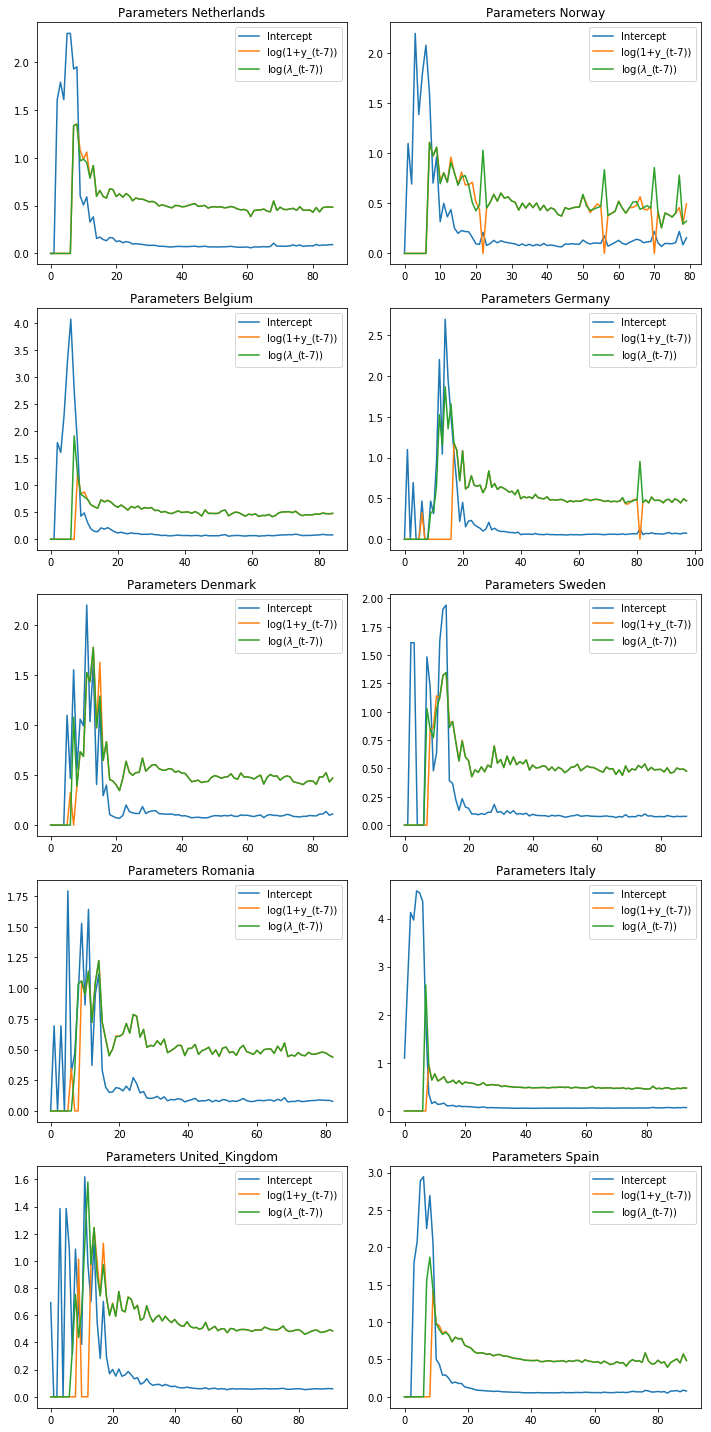

In [56]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, parameters, country in zip(axes.ravel(), paramsAll, dataframes):
    ax.plot(parameters)
    ax.set_title('Parameters '+country.loc[0,['country']].values[0])
    ax.legend(['Intercept', 'log(1+y_(t-7))', 'log($\lambda$_(t-7))'])
#     ax.set_xlabel('Day')
#     ax.set_ylabel('Cases')
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()

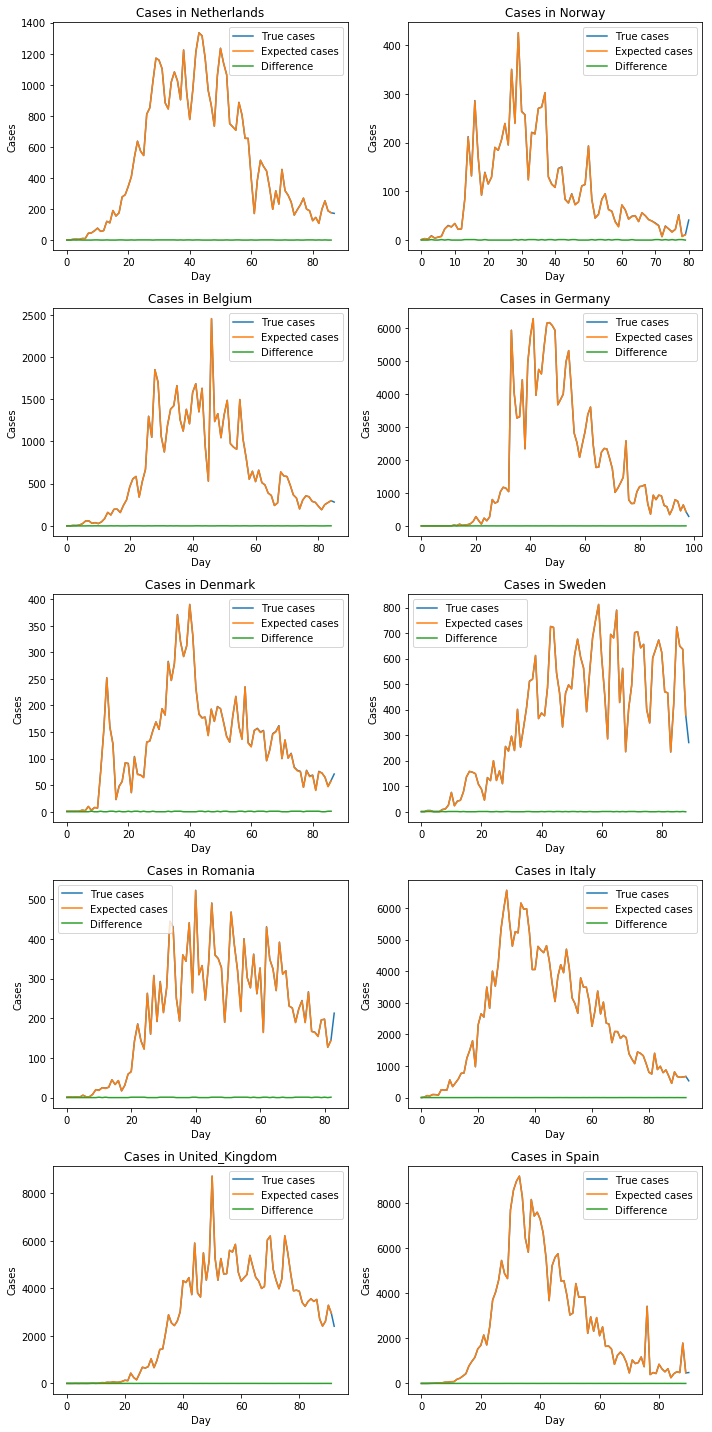

In [66]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country in zip(axes.ravel(), dataframes):

    ax.plot(country[['cases']].values)
    ax.plot(country[['expcasestoday']].values)
    ax.plot(country[['cases']].values-country[['expcasestoday']].values)
#     country.plot(y=['cases', 'expcasestoday'], ax=ax, legend=False)
#     country.plot(x='date', y='expcasestoday', ax=ax, legend=False)
#     country[['cases', 'expcasestoday']].plot()

#     ax = country.plot(y="cases")
#     country.plot(y="expcasestoday", ax=ax)

#     country.plot(x='date', y='cases')
    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True cases', 'Expected cases', 'Difference'])
#     ax.set_xticklabels(country[['date']].values, rotation=90)

fig.tight_layout()

### Global Model

In [87]:
paramest = []
for parameters in paramsAll[0:5]: 
    paramest.append(np.median(parameters[30:], axis = 0))

In [88]:
coefficients = np.median(paramest, axis = 0)

In [89]:
coefficients

array([0.07369012, 0.48130691, 0.48062633])

In [90]:
for country in dataframes: 
    for i in range(7):
        country.loc[i,'expcasesweekGLOBAL']=0

In [91]:
for country in dataframes: 
    for i in range(0, len(country)):
        y = coefficients[0] + coefficients[1]*(np.log(1+ country.loc[i]['casesweek'])) + coefficients[2]*(np.log(1+ country.loc[i]['expcasesweekGLOBAL']))
        if (i < len(country)):
            country.loc[i+7,'expcasesweekGLOBAL']=np.exp(y)
        country.loc[i,'expcasestodayGLOBAL']=np.exp(y)

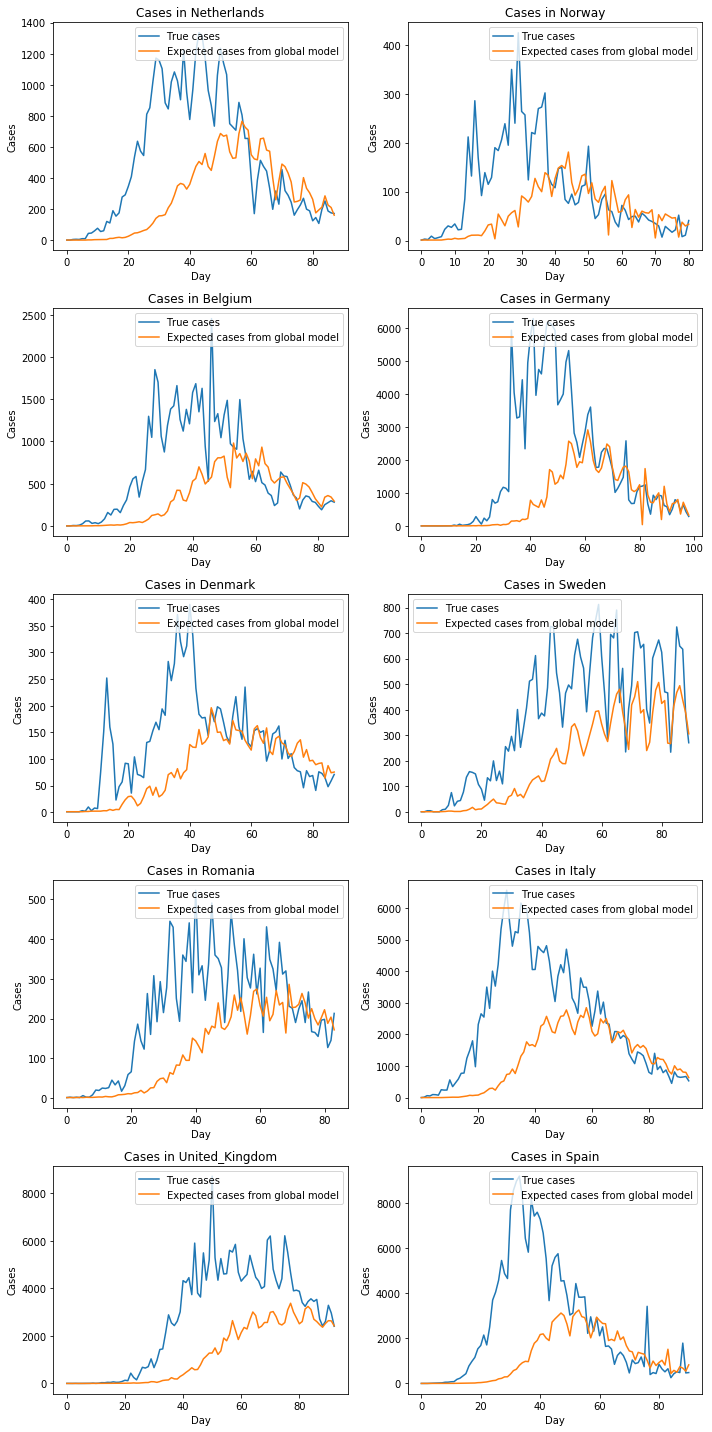

In [92]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for ax, country in zip(axes.ravel(), dataframes):
    ax.plot(country[['cases']].values)
    ax.plot(country[['expcasestodayGLOBAL']].values)
#     ax.plot(country[['cases']].values-country[['expcasestodayGLOBAL']].values)

    ax.set_title('Cases in '+country.loc[0,['country']].values[0])
    ax.set_xlabel('Day')
    ax.set_ylabel('Cases')
    ax.legend(['True cases', 'Expected cases from global model', 'Difference'])

fig.tight_layout()